# Class imbalance ⚖️ 

In [1]:
import pandas as pd
import numpy as np
from numpy import where
from numpy import unique

import matplotlib.pyplot as plt
from numpy import hstack
from numpy import vstack

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

## What is class imbalance and why could it be a problem for making predictions?

In [2]:
# generate dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=42, cluster_std=3)

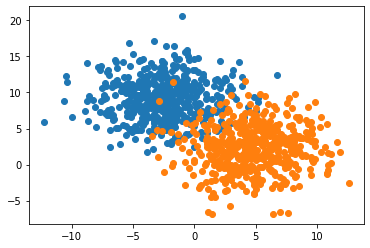

In [3]:
# create scatter plot for samples from each class
for class_value in range(2):
	row_ix = where(y == class_value)             # get row indexes for samples with this class
	plt.scatter(X[row_ix, 0], X[row_ix, 1])      # create scatter of these samples
plt.show()

### Compare this with an "imbalanced" dataset:

In [4]:
proportions = {0:10000, 1:1000} 

def get_dataset(proportions):
	"""create a dataset with a given class distribution"""
	n_classes = len(proportions)                                # determine the number of classes
	largest = max([v for k,v in proportions.items()])           # determine the number of examples to generate for each class
	n_samples = largest * n_classes
	X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=2, random_state=42, cluster_std=3)
	X_list, y_list = list(), list()                             # collect the examples
	for k,v in proportions.items():
		row_ix = where(y == k)[0]
		selected = row_ix[:v]
		X_list.append(X[selected, :])
		y_list.append(y[selected])
	return vstack(X_list), hstack(y_list)


def plot_dataset(X, y):
	"""create scatter plot for samples from each class"""
	n_classes = len(unique(y))
	for class_value in range(n_classes):
		row_ix = where(y == class_value)[0]                      # get row indexes for samples with this class
		plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(class_value))  # create scatter of these samples
	plt.legend()                                                 # show a legend
	plt.show()                                  

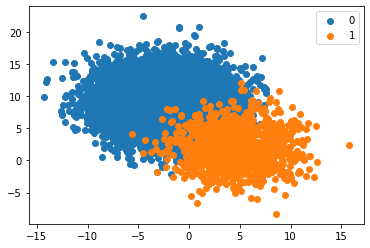

In [42]:
# define the class distribution
proportions = {0:10000, 1:1000} # i.e.: for each "positive class" instance, there are 10 "negative class" instances
X, y = get_dataset(proportions)                     
plot_dataset(X, y)                                

### Compare this to even more unevenly distributed classes:

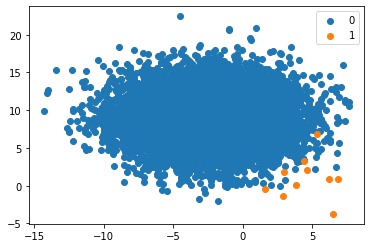

In [44]:
proportions = {0:10000, 1:10} # i.e.: for each "1" instance, there are 1.000 "0" instances                   
X, y = get_dataset(proportions)                     
plot_dataset(X, y)                                  

## Why is such a class distribution a problem?

#### Let's use the creditcard dataset (see http://krspiced.pythonanywhere.com/chapters/project_lyrics/class_imbalance/README.html)

In [7]:
df = pd.read_csv("../data/creditcard.zip", index_col=0)
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [8]:
X = df.iloc[:,:-1] 
y = df["Class"]
X.shape, y.shape 

((284807, 27), (284807,))

In [9]:
df["Class"].value_counts() / df.shape[0]

0    0.998273
1    0.001727
Name: Class, dtype: float64

- **Because** of class imbalance in the dataset, **any model will be a lot more exposed to the majority class**, **"negative class"** or **"0"**) => predictions will be biased towards majority class.
- In fact, just by looking at the distribution, we could easily set up a **no skill model** generalizing that **there a NO fraud cases**

In [55]:
y_pred = np.zeros(df.shape[0])
len(y_pred)
unique(y_pred)

array([0.])

#### ...but what's the "price" we pay for using this (admittedly trivial) model? 
- in practice:
    - consider the loss that one single, big fraud case (or many small ones accumulated) can generate for a financial institution as a whole (e.g. so-called "Loan Loss Provisions" eating up profits)
    - unfortunately, in the pandemic we have also learned first-hand what negative consequences a false prediction of **negatives** can have...

#### So, "no skill" model doesn't seem very convincing...but let's give it a chance evaluating it with a formal metric such as "accuracy".

$$ accuracy = (TP+TN)/(TP+FP+TN+FN)$$ 

In [52]:
TP = 0            # dummy model states there are 0 positives, but in reality there ARE positives => 0 true predictions re positive class 
FP = 0.001727*df.shape[0]     # dummy model states there are 0 positives, but in reality there ARE positives => 0.001727 are false predictions re positive class 
TN = 0.998273*df.shape[0]     # dummy model states there are 100% negatives, but in reality there 0.998273 negatives => 0.998273 are true predictions re negative class
FN = 0            # dummy model states there are 100% negatives, but in reality there 0.998273 negatives => 0.001727 are false predictions re negative class

In [53]:
accuracy = (TP + TN)/(TP+FP+TN+FN)
accuracy

0.9982730000000001

In [33]:
y_pred = np.zeros(df.shape[0])
y_true = y

In [34]:
accuracy_score(y_true, y_pred)

0.9982725143693799

## Accuracy actually indicates that "no skill"-model performs quite well! 🤔
- => **underlying assumption** is that **number of correct predictions** should be **maximized**
- => instead, you could evaluate binary classification models by **how well they discriminate between classes**, which lies at the center of "ranking metrics" (e.g. ROC)

## How can we deal with these challenges?

- use the evaluation metrics 🕙 🕞 🕚 that account for class imbalance...
- in addition: adapt training 🔨💰 of model in such way that class imbalance is being accounted for 
- (compare more than one models to each other and select best-performing one 🤓)
- (resample data 📲)

## 1. Cost-sensitive Learning 🔨💰

### "Cost-sensitive learning (...) takes the costs of prediction errors (...) into account when training a machine learning model. (...) many conceptualizations and techniques developed and used for cost-sensitive learning can be adopted for imbalanced classification problems."  - Ibid.

### "The purpose of CSL is to build a model with minimum misclassification costs (total cost)"  - Cost-sensitive Learning Methods For Imbalanced Data, 2010.

- Let's fit a simple **LogReg model** 
- initially **without weights being assigned to log loss function**, i.e.:

$$ loss = - (log(yhat_{i}) * y_{i} + log(1 - yhat_{i}) * (1 - y_{i}))$$ 

In [14]:
X = X.copy() 
y = y.copy()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) # remember: you set "stratify" so that train data and labelled data have the same "proportions" re classes...
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((213605, 27), (71202, 27), (213605,), (71202,))

In [16]:
LogReg_unweighted = LogisticRegression(solver="lbfgs")    # instantiating the model

In [17]:
LogReg_unweighted.fit(X_train, y_train)

/Users/carlospumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

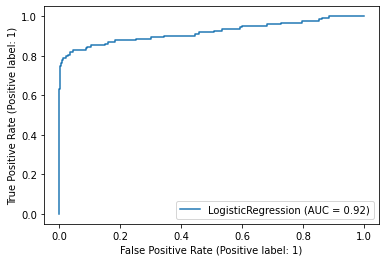

In [18]:
ROC_LogReg_unweighted = plot_roc_curve(LogReg_unweighted, X_test, y_test)
plt.show()


## LogReg classifier
- is an effective model for binary classification tasks
- by default, it is **not effective at imbalanced classification**
- it can be modified to be better suited for imbalanced classification by means of introducing weights:
    - the **weighting** is applied to the loss **so that smaller weight values result in a smaller error value**, and in turn, **less update** to the model **coefficients**.
    - a **larger weight** value results in a **larger error calculation**, and in turn, **more update** to the model **coefficients**.

### Back to LogReg, now WITH weights - formally:

$$ - (w_{0} * log(yhat_{i}) * y_{i} + w_{1} * log(1 - yhat_{i}) * (1 - y_{i}))$$ 

- **small weight** => less importance & smaller updates of coefficients
- **large weight** => more importance & larger updates of coefficients

In [37]:
weights = {0:0.01, 1:1.0} # hyperparams!

In [39]:
LogReg_weighted = LogisticRegression(solver="lbfgs", class_weight=weights) # note explicit spec of "weights" param

In [21]:
LogReg_weighted.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.01, 1: 1.0})

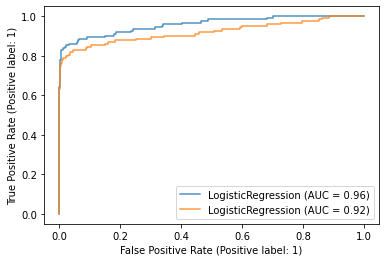

In [22]:
ax = plt.gca()

ROC_LogReg_weighted = plot_roc_curve(LogReg_weighted, X_test, y_test, ax=ax, alpha=0.8)
ROC_LogReg_unweighted.plot(ax=ax, alpha=0.8)

plt.show() 

### Clearly, weighting cost function improves performance of LogReg on this imbalanced dataset (0.96 vs 0.92)!

- ok, but: **why** is **ROC AUC better metric** for **imbalanced** datasets?

## 2. Use the right evaluation metrics 🕙 🕞 🕚: the ROC AUC ("Receiver Operating Characteristic, Area Under the Curve")

## Intuition ROC 
- intuition ROC: a **curve** of **combinations** of **FP-rate** (x-axis) and **TP-rate** (y-axis) for a set of predictions by a classifier **under different thresholds**
- note the **trade-off** between TP-rates and FP-rates (i.e. the **shape of the curve**)
- helpful for evaluating **one model** (binary classification) **under different thresholds**

## Intuition ROC AUC
- intuition **AUC**: the **score** resulting from **area** below ROC
- more precisely: probability, that the scores given by a classifier will rank a randomly chosen positive instance high than a randomly chosen negative one
- helpful for evaluating **more than one model to each other** (binary classification)

## Which category of metrics does ROC AUC belong to?
- it belongs to the category of **ranking metrics**: how well can these models discriminate between classes for different thresholds? => rank them based on this criterion
- in comparison: metrics such as **accuracy, precision, recall and f-scores** belong to the **threshold metrics** (criterion: maximizing % correct predictions (or: minimizing % false predictions))
- finally, a **third category** of metrics are **probability-based** metrics (criterion: minimizing error between predicted probability distribution and real probability distribution)